In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

## Try to find bistability and oscillation frequency

In [2]:
def RectifiedInput(amplitude, n=1):
    """
    Return rectified input with exponential decay, i.e. a negative step followed by a
    slow decay to zero, followed by a positive step and again a slow decay to zero.
    Can be used for bistablity detection.

    :param amplitude: Amplitude (both negative and positive) for the step
    :type amplitude: float
    :param n: Number of realizations (spatial dimension)
    :type n: int
    :return: Concatenated input which represents the rectified stimulus with exponential decay
    :rtype: `ConctatenatedInput`
    """

    return stim.ConcatenatedStimulus(
        [
            stim.StepInput(step_size=-amplitude, n=n),
            stim.ExponentialInput(inp_max=amplitude, exp_type="rise", exp_coef=12.5, n=n)
            + stim.StepInput(step_size=-amplitude, n=n),
            stim.StepInput(step_size=amplitude, n=n),
            stim.ExponentialInput(amplitude, exp_type="decay", exp_coef=7.5, n=n),
            stim.StepInput(step_size=0.0, n=n),
        ],
        length_ratios=[0.5, 2.5, 0.5, 1.5, 10.0],
    )


In [3]:
aln = ALNModel()
dt = aln.params['dt']
aln.params['duration'] = 15 * 1000 # in ms
aln.params['dt'] = 0.1
aln.params['sigma_ou'] = 0.
aln.params['de'] = 4.
aln.params['di'] = 2.
# no adaptation
aln.params['a'] = 0.
aln.params['b'] = 0. 

aln.params['mue_ext_mean'] = 2.5
aln.params['mui_ext_mean'] = 2.5

stimulus = RectifiedInput(1).to_model(aln)
aln.params['ext_exc_current'] = stimulus
aln.run()

INFO:root:aln: Model initialized.


ic| bi_amp: 46.16610580363832, osc: 0.0, freq: nan


(46.16610580363832, 0.0, nan)

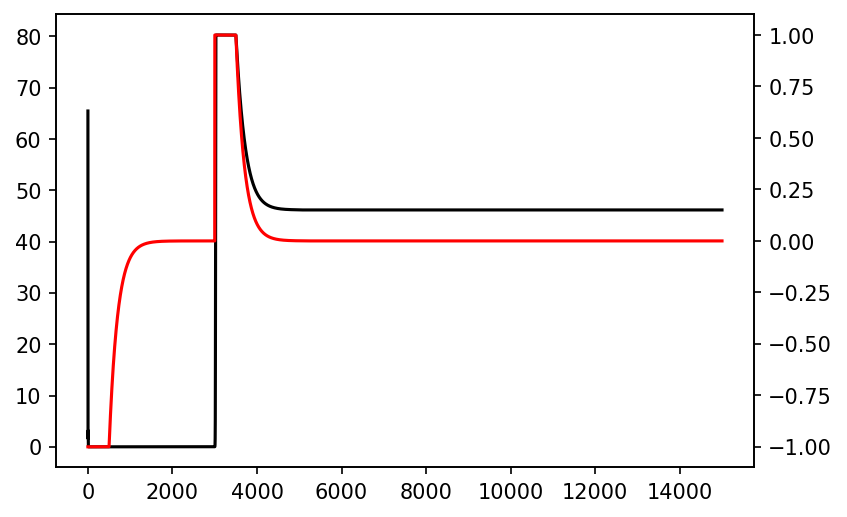

In [4]:
fig, ax = plt.subplots(dpi=150)
ax.plot(aln.t, aln.rates_exc[0], c="black")
ax2 = plt.twinx(ax)
ax2.plot(aln.t, aln.params['ext_exc_current'][0], c="red")

r1 = np.max(aln.rates_exc[0][int(2000 / aln.params.dt) : int(2900 / aln.params.dt)])
r2 = np.max(aln.rates_exc[0][int(7000 / aln.params.dt) : int(8000 / aln.params.dt)])

bi_amp = np.abs(r1 - r2)

osc = np.max(aln.rates_exc[0][-int(300 / aln.params.dt):]) - np.min(aln.rates_exc[0][-int(300 / aln.params.dt)])

try:
    freq = dom_frequency(aln.rates_exc[0][int(8000 / aln.params.dt): ])
except:
    freq = np.nan
    
ic(bi_amp, osc, freq)

In [5]:
aln = ALNModel()
dt = aln.params['dt']
aln.params['duration'] = 20 * 1000 # in ms
aln.params['dt'] = 0.1
aln.params['sigma_ou'] = 0.
aln.params['de'] = 4.
aln.params['di'] = 2.
# no adaptation
aln.params['a'] = 0.
aln.params['b'] = 0. 

aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5

stimulus = RectifiedInput(1).to_model(aln)
aln.params['ext_exc_current'] = stimulus
aln.run()

INFO:root:aln: Model initialized.


ic| bi_amp: 0.007609737525704929, osc: 9.879322912169101, freq: 21.25


(0.007609737525704929, 9.879322912169101, 21.25)

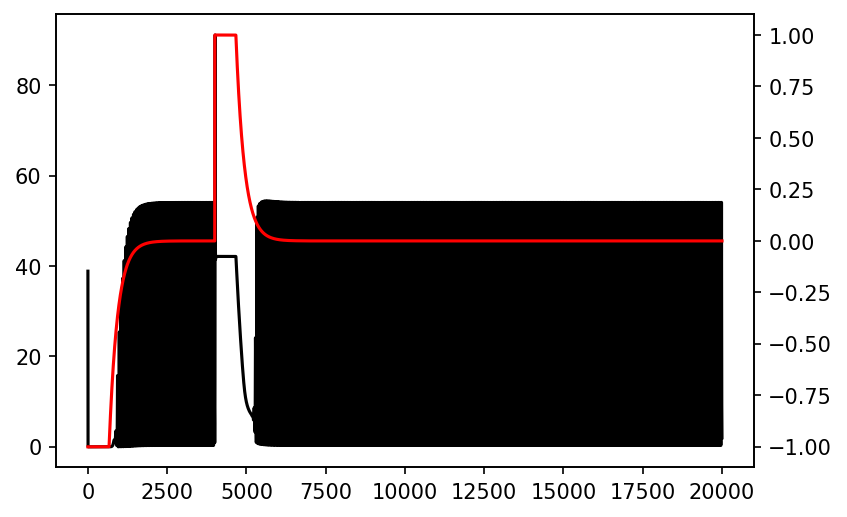

In [6]:
fig, ax = plt.subplots(dpi=150)
ax.plot(aln.t, aln.rates_exc[0], c="black")
ax2 = plt.twinx(ax)
ax2.plot(aln.t, aln.params['ext_exc_current'][0], c="red")

r1 = np.max(aln.rates_exc[0][int(2000 / aln.params.dt) : int(2900 / aln.params.dt)])
r2 = np.max(aln.rates_exc[0][int(7000 / aln.params.dt) : int(8000 / aln.params.dt)])

bi_amp = np.abs(r1 - r2)

osc = np.max(aln.rates_exc[0][-int(300 / aln.params.dt):]) - np.min(aln.rates_exc[0][-int(300 / aln.params.dt)])

try:
    freq = dom_frequency(aln.rates_exc[0][int(8000 / aln.params.dt): ],
                        dt=aln.params.dt,
                        SP_WINDOW=100)
except:
    freq = np.nan
    
ic(bi_amp, osc, freq)

# Pic of OneNode Frequncies depending on $\mu_e$ and $\mu_I$

In [7]:
aln = ALNModel()
dt = aln.params['dt']
aln.params['duration'] = 15 * 1000 # in ms
aln.params['dt'] = 0.1
aln.params['sigma_ou'] = 0.
aln.params['de'] = 4.
aln.params['di'] = 2.
# no adaptation
aln.params['a'] = 0.
aln.params['b'] = 0. 

INFO:root:aln: Model initialized.


In [8]:
def mdom_frequency(ts, dt=0.1, SP_WINDOW=100, peak_h=-20):
    ps = func.getPowerSpectrum(ts,
                              dt,
                              maxfr=100,
                              spectrum_windowsize=SP_WINDOW) # powerspectrum 
    peaks, props = find_peaks(ps[1].T, height = peak_h)
    return ps[0][peaks[props['peak_heights'].argmax()]],  max(props['peak_heights']) # dominant frequency of ts 


def evalf(traj):
    pars = search.getParametersFromTraj(traj)
    aln.params['mue_ext_mean'] = pars['mue_ext_mean']
    aln.params['mui_ext_mean'] = pars['mui_ext_mean']
    
    stimulus = RectifiedInput(1).to_model(aln)
    aln.params['ext_exc_current'] = stimulus
    
    aln.run()
    
    r1 = np.max(aln.rates_exc[0][int(2000 / aln.params.dt) : int(2900 / aln.params.dt)]) # negative stimulus
    r2 = np.max(aln.rates_exc[0][int(7000 / aln.params.dt) : int(8000 / aln.params.dt)]) # positive stimulus
    
    max_re = np.max(aln.rates_exc[0][-int(300 / aln.params.dt):])
    min_re = np.min(aln.rates_exc[0][-int(300 / aln.params.dt):])
    max_ri = np.max(aln.rates_inh[0][-int(300 / aln.params.dt):])
    min_ri = np.min(aln.rates_inh[0][-int(300 / aln.params.dt):])

    bi_amp = np.abs(r1 - r2)
  
    try:
        freq = dom_frequency(aln.rates_exc[0][int(8000 / aln.params.dt): ],
                            dt=aln.params.dt,
                            SP_WINDOW=100)
    except:
        freq = np.nan
        
    result_dict = {"frequency" : freq,
                   "max_re" : max_re,
                   "min_re" : min_re, 
                   "max_ri" : max_ri,
                   "min_ri" : min_ri,
                   "bi_amp" : bi_amp}

    search.saveToPypet(result_dict, traj)


In [9]:
mue = np.linspace(0, 2.5, 31)
mui = np.linspace(0, 2.5, 31)
#mue = [1.]
#mui = [1.]
parameters = ParameterSpace({"mue_ext_mean": mue,
                             "mui_ext_mean": mui})
#parameters = ParameterSpace({"signalV": [1],
#                             "Ke_gl": [100]})
search = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   #filename=HDF_PATH+'TwoNode_delay_stim_LCmiddle_multistab.hdf')
                    filename=HDF_PATH+'OneNode_Frequencies_from_mue_mui_highres_w_classification_highres.hdf')

INFO:root:Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/OneNode_Frequencies_from_mue_mui_highres_w_classification_highres.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 961
MainProcess root INFO     BoxSearch: Environment initialized.


In [10]:
#search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-12-17-09H-55M-19S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2021-12-17-09H-55M-19S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2021-12-17-09H-55M-19S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2021-12-17-09H-55M-19S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [10]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/OneNode_Frequencies_from_mue_mui_highres_w_classification_highres.hdf
MainProcess root INFO     Analyzing trajectory results-2021-12-20-09H-55M-01S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/OneNode_Frequencies_from_mue_mui_highres_w_classification_highres.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-12-20-09H-55M-01S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 75 nodes in 0m22s (3.36 nodes/s).
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 3

In [11]:
df = search.dfResults

In [12]:
for i in search.dfResults.index:
    search.dfResults.loc[i, 'period'] = 1000 / search.dfResults['frequency'][i]
    search.dfResults.loc[i, 'amp_re'] = search.dfResults['max_re'][i] - search.dfResults['min_re'][i]
    search.dfResults.loc[i, 'amp_ri'] = search.dfResults['max_ri'][i] - search.dfResults['min_ri'][i]

In [13]:
for i in search.dfResults.index:
    if search.dfResults['amp_re'][i] > 0.1:
        search.dfResults.loc[i,'state'] = 1
    else:
        search.dfResults.loc[i,'state'] = 0
        search.dfResults.loc[i, 'frequency'] = -1

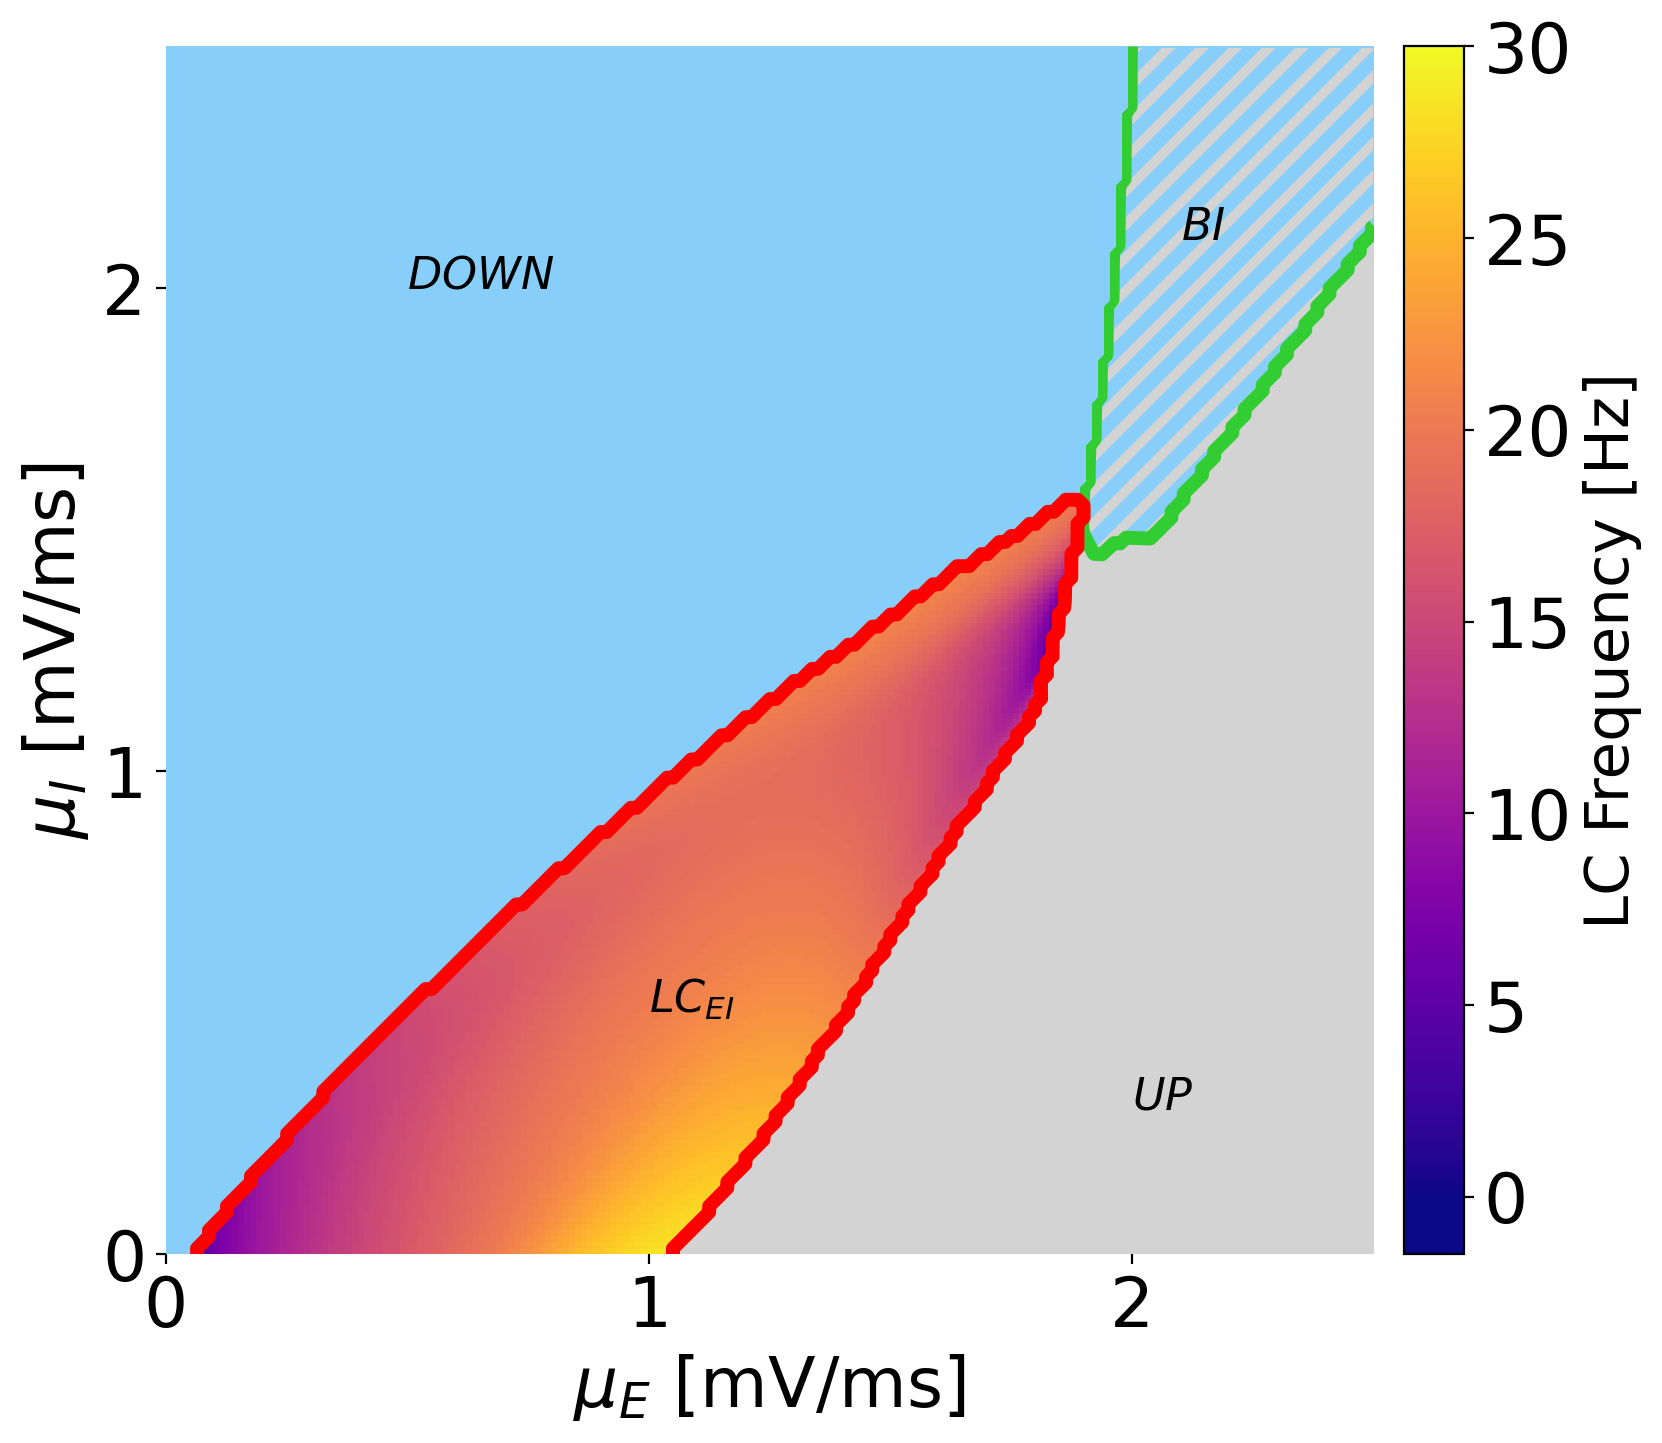

In [14]:
plt.rc('hatch', linewidth=5)

fig, ax = plt.subplots(figsize=(9,8), dpi=200)

#ax.set_title("$d_E = {0:.3}$ ms, $d_I = {1:.3}$ ms".format(x,y),size= 20)
#df = dfResults[(dfResults.de == x)&(dfResults.di == y)]
#masked_array = np.ma.masked_where(df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean') == -1,
#                                  df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'))


# FREQUENCY 
cmap = matplotlib.cm.plasma
#cmap.set_under(color='lightgrey')
masked_array = np.ma.masked_where(df.pivot_table(values='state', index = 'mui_ext_mean', columns='mue_ext_mean') != 1,
                                      df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'))
img = ax.imshow(masked_array, 
   extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
            min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], 
                origin='lower',
                vmin=0,
                vmax=30,
               cmap=cmap
               ,zorder=5)

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.tick_params(axis='both', labelsize=25)     
ax.set(frame_on=False) 
ax.set_xlabel(r"$\mu_E$ [mV/ms]", size=25)
ax.set_ylabel(r"$\mu_I$ [mV/ms]", size=25)

# PATCH
rec1 = plt.Rectangle((1,1),1.5,1.5, facecolor="lightgrey", 
                     edgecolor="lightskyblue", hatch=r"//" , zorder=1)

ax.add_patch(rec1)

# CONTOUR 

df2 = df.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0, 15], linewidths=3, colors="lightgrey", zorder=2)


df2 = df.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [14], linewidths=5, colors="limegreen")

## DOWN-STATE
df2 = df.pivot_table('min_re', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0,4], linewidths=3, colors="lightskyblue", zorder=2)


df2 = df.pivot_table('frequency', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [0.1], linewidths=5, colors="red", zorder=6)



# TEXT 
ax.text(0.5, 2,r"$DOWN$", fontsize=16)
ax.text(2, 0.3,r"$UP$", fontsize=16)
ax.text(2.1, 2.1,r"$BI$", fontsize=16)
ax.text(1, 0.5,r"$LC_{EI}$", fontsize=16, zorder=6)


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
cbar = fig.colorbar(img, cax=cax,extend="min", extendfrac=0.05, extendrect=True)
cbar.ax.set_ylabel("LC Frequency [Hz]",size=22)
cbar.ax.tick_params(labelsize=25)
#plt.suptitle("Limit Cycle in State Space",size= 30)
#plt.savefig(HOME_PATH+"Plots/Bifurcation/Motif_highres.pdf")

# **Same Pic for Parametrization with I-I LC**

In [15]:
def evalf():
    pass

mue = np.linspace(0, 2.5, 51)
mui = np.linspace(0, 2.5, 51)
#mue = [1.]
#mui = [1.]
parameters = ParameterSpace({"mue_ext_mean": mue,
                             "mui_ext_mean": mui})
#parameters = ParameterSpace({"signalV": [1],
#                             "Ke_gl": [100]})
search2 = BoxSearch(evalFunction = evalf,
                   parameterSpace=parameters,
                   #filename=HDF_PATH+'TwoNode_delay_stim_LCmiddle_multistab.hdf')
                   #filename=HDF_PATH+'OneNode_Frequencies_from_mue_mui_di=9_highres.hdf')
                   filename=HDF_PATH+'OneNode_Frequencies_from_mue_mui_di=9_w_classification_highres.hdf')

MainProcess root INFO     Number of processes: 4
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/OneNode_Frequencies_from_mue_mui_di=9_w_classification_highres.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 2601
MainProcess root INFO     BoxSearch: Environment initialized.


In [16]:
search2.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/OneNode_Frequencies_from_mue_mui_di=9_w_classification_highres.hdf
MainProcess root INFO     Analyzing trajectory results-2022-01-03-14H-21M-53S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/OneNode_Frequencies_from_mue_mui_di=9_w_classification_highres.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-01-03-14H-21M-53S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 75 nodes in 0m22s (3.29 nodes/s).
MainProcess pypet.storageservice.HDF5StorageService INFO     Processed 29708 n

## new pic with by

In [17]:
dfi = search2.dfResults

In [18]:
for i in search2.dfResults.index:
    #search2.dfResults.loc[i, 'period'] = 1000 / search2.dfResults['frequency'][i]
    search2.dfResults.loc[i, 'amp_re'] = search2.dfResults['max_re'][i] - search2.dfResults['min_re'][i]
    search2.dfResults.loc[i, 'amp_ri'] = search2.dfResults['max_ri'][i] - search2.dfResults['min_ri'][i]

In [19]:
for i in search2.dfResults.index:
    if (search2.dfResults['amp_ri'][i] > 0.1) | (search2.dfResults['amp_re'][i] > 0.1):
        search2.dfResults.loc[i,'state'] = 1
        search2.dfResults.loc[i, 'frequency'] = search2.dfResults['frequency_i'][i]
    #if (search2.dfResults['amp_ri'][i] > 0.1) or (search2.dfResults['amp_re'][i] > 0.1):
    #    search2.dfResults.loc[i,'state'] = 1
    else:
        search2.dfResults.loc[i,'state'] = 0
        search2.dfResults.loc[i, 'frequency'] = 0.

In [20]:
plt.rc('hatch', linewidth=5)

fig, ax = plt.subplots(figsize=(9,8), dpi=200)

#ax.set_title("$d_E = {0:.3}$ ms, $d_I = {1:.3}$ ms".format(x,y),size= 20)
#df = dfResults[(dfResults.de == x)&(dfResults.di == y)]
#masked_array = np.ma.masked_where(df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean') == -1,
#                                  df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'))


# FREQUENCY 
cmap = matplotlib.cm.plasma
#cmap.set_under(color='lightgrey')
masked_array = np.ma.masked_where(dfi.pivot_table(values='state', index = 'mui_ext_mean', columns='mue_ext_mean') != 1,
                                      dfi.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'))
img = ax.imshow(masked_array, 
   extent = [min(search2.dfResults.mue_ext_mean), max(search2.dfResults.mue_ext_mean),
            min(search2.dfResults.mui_ext_mean), max(search2.dfResults.mui_ext_mean)], 
                origin='lower',
                vmin=0,
                vmax=30,
               cmap=cmap
               ,zorder=5)

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.tick_params(axis='both', labelsize=25)     
ax.set(frame_on=False) 
ax.set_xlabel(r"$\mu_E$ [mV/ms]", size=25)
ax.set_ylabel(r"$\mu_I$ [mV/ms]", size=25)

# PATCH
rec1 = plt.Rectangle((1,1),1.5,1.5, facecolor="lightgrey", 
                     edgecolor="lightskyblue", hatch=r"//" , zorder=1)

ax.add_patch(rec1)

# CONTOUR 

dfi2 = dfi.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0, 15], linewidths=3, colors="lightgrey", zorder=2)


dfi2 = dfi.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [15], linewidths=5, colors="limegreen", zorder=3)

## DOWN-STATE
dfi2 = dfi.pivot_table('min_re', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0,4], linewidths=3, colors="lightskyblue", zorder=2)


dfi2 = dfi.pivot_table('frequency', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [0.1], linewidths=5, colors="red", zorder=6)



# TEXT 
ax.text(0.4, 2,r"$DOWN$", fontsize=16)
ax.text(2, 0.5,r"$UP$", fontsize=16)
ax.text(2.1, 2.1,r"$BI$", fontsize=16)
ax.text(1, 0.5,r"$LC_{EI}$", fontsize=16, zorder=6)
ax.text(0.4, 1.1,r"$LC_{II}$", fontsize=16, zorder=6)


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.15)
cbar = fig.colorbar(img, cax=cax,extend="min", extendfrac=0.05, extendrect=True)
cbar.ax.set_ylabel("LC Frequency [Hz]",size=22)
cbar.ax.tick_params(labelsize=25)
cbar.ax.spines["bottom"].set_bounds(low=0, high=30)
cbar.ax.set_ylim(0, 30)
#plt.suptitle("Limit Cycle in State Space",size= 30)
#plt.savefig(HOME_PATH+"Plots/Bifurcation/Motif_highres.pdf")

(0.0, 30.0)

## both next to each other

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

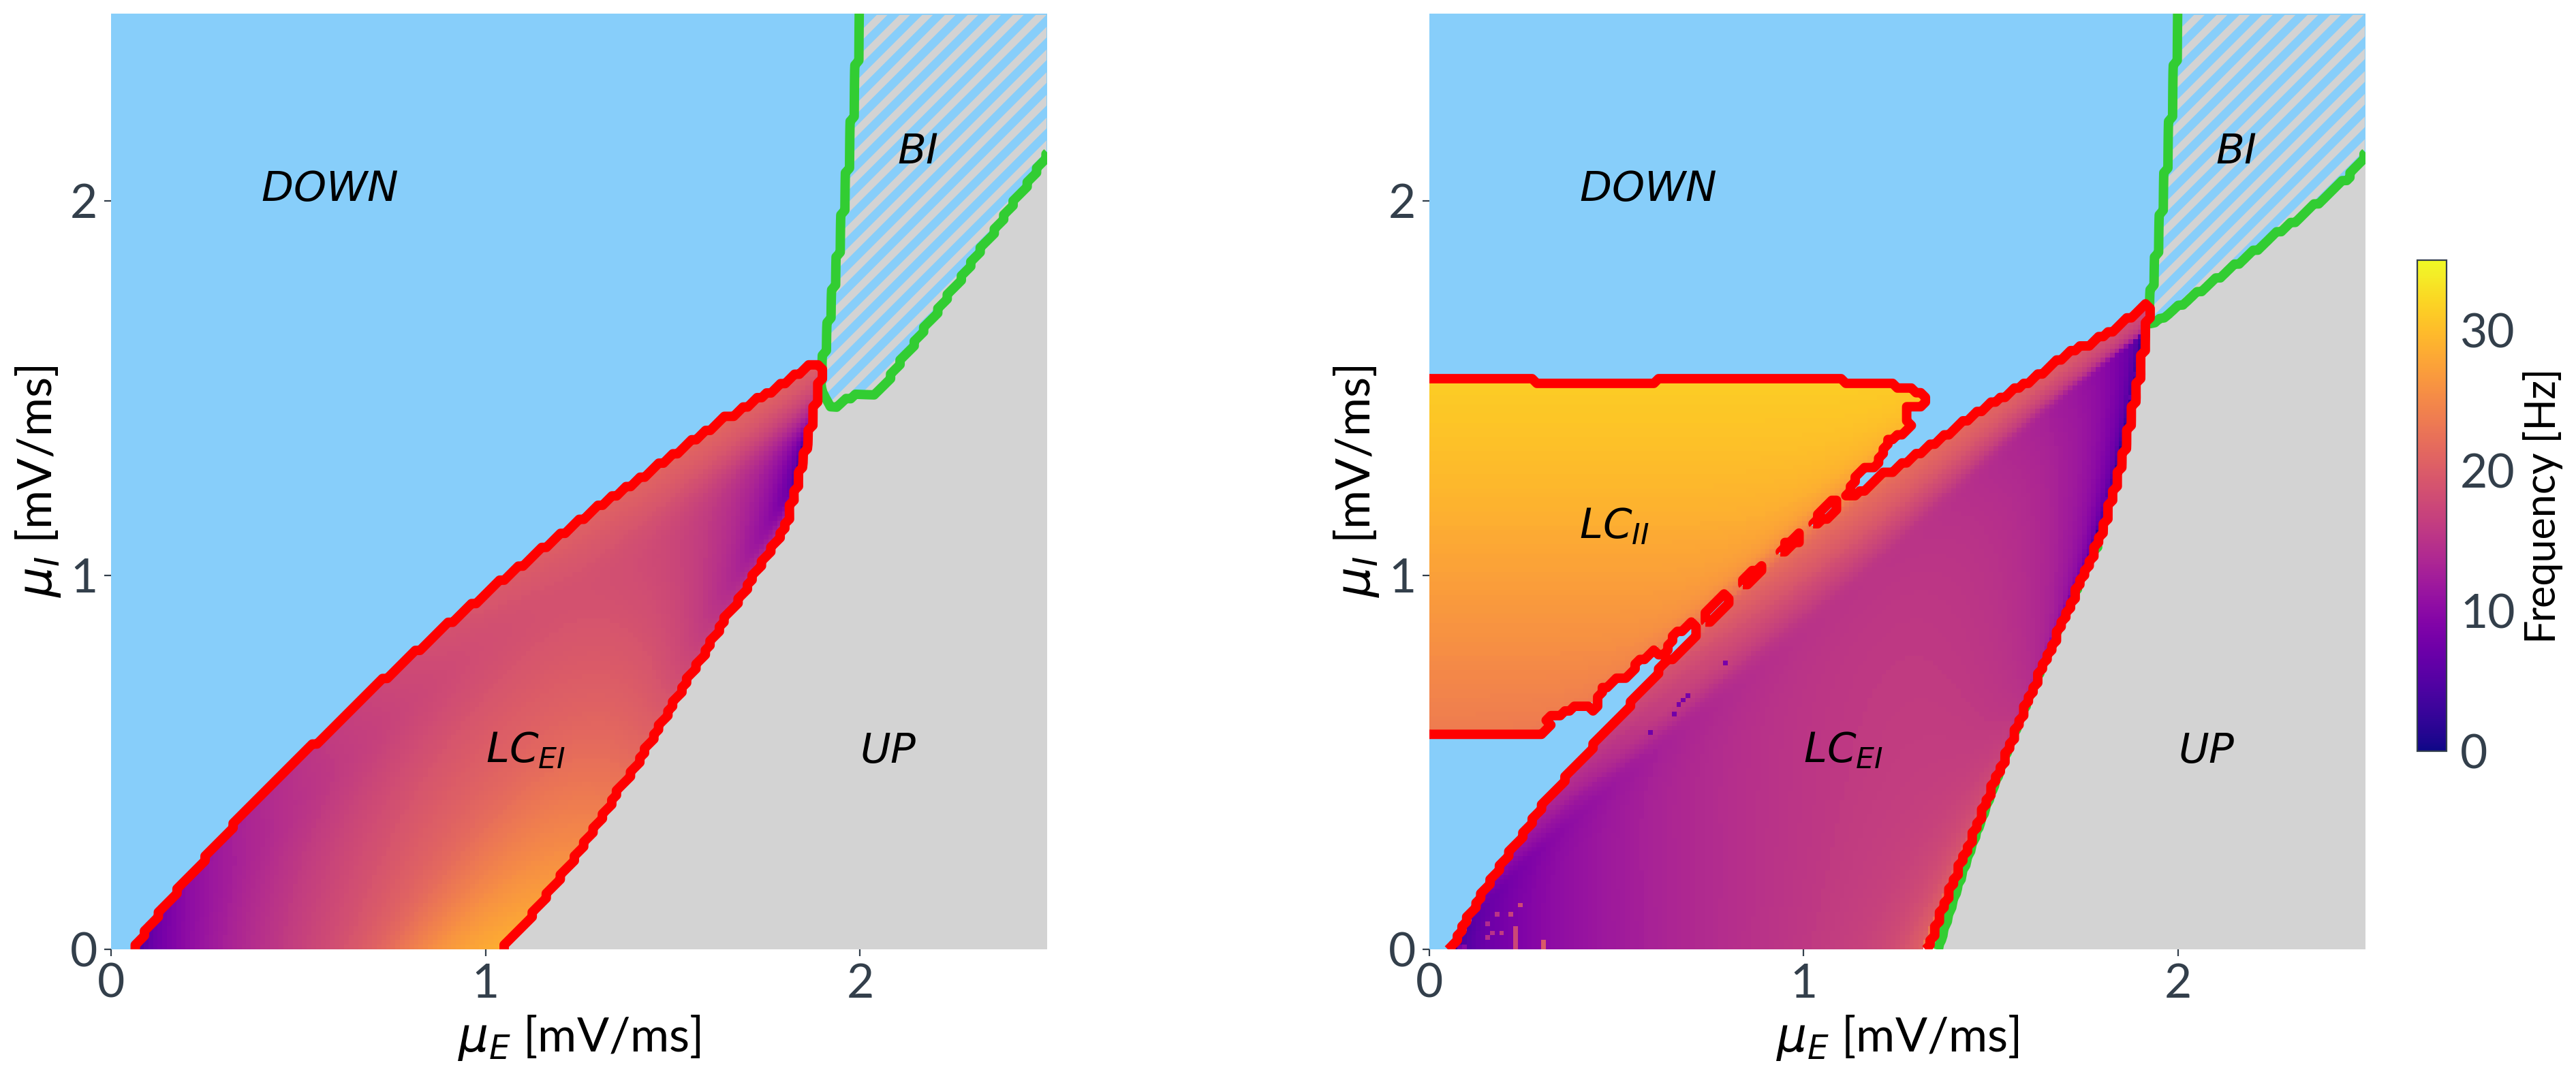

In [22]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

plt.rc('hatch', linewidth=4.5)

fig, axs = plt.subplots(1,2, figsize=(20, 8), dpi=200)

ax = axs[0]
# FREQUENCY 
cmap = matplotlib.cm.plasma
#cmap.set_under(color='lightgrey')
masked_array = np.ma.masked_where(df.pivot_table(values='state', index = 'mui_ext_mean', columns='mue_ext_mean') != 1,
                                      df.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'))
img = ax.imshow(masked_array, 
   extent = [min(search.dfResults.mue_ext_mean), max(search.dfResults.mue_ext_mean),
            min(search.dfResults.mui_ext_mean), max(search.dfResults.mui_ext_mean)], 
                origin='lower',
                vmin=0,
                vmax=35,
               cmap=cmap
               ,zorder=5)

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.tick_params(axis='both', labelsize=25)     
ax.set(frame_on=False) 
ax.set_xlabel(r"$\mu_E$ [mV/ms]", size=25)
ax.set_ylabel(r"$\mu_I$ [mV/ms]", size=25)

# PATCH
rec1 = plt.Rectangle((1,1),1.5,1.5, facecolor="lightgrey", 
                     edgecolor="lightskyblue", hatch=r"//" , zorder=1)

ax.add_patch(rec1)

# CONTOUR 

df2 = df.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0, 15], linewidths=3, colors="lightgrey", zorder=2)


df2 = df.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [14], linewidths=5, colors="limegreen", zorder=3)

## DOWN-STATE
df2 = df.pivot_table('min_re', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0,4], linewidths=3, colors="lightskyblue", zorder=2)


df2 = df.pivot_table('frequency', 'mui_ext_mean', 'mue_ext_mean')
X=df2.columns.values
Y=df2.index.values
Z=df2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [0.1], linewidths=5, colors="red", zorder=6)



# TEXT 
ax.text(0.4, 2,r"$DOWN$", fontsize=22)
ax.text(2, 0.5,r"$UP$", fontsize=22)
ax.text(2.1, 2.1,r"$BI$", fontsize=22)
ax.text(1, 0.5,r"$LC_{EI}$", fontsize=22, zorder=6)






ax = axs[1]
# FREQUENCY 
cmap = matplotlib.cm.plasma
#cmap.set_under(color='lightgrey')
masked_array = np.ma.masked_where(dfi.pivot_table(values='state', index = 'mui_ext_mean', columns='mue_ext_mean') != 1,
                                      dfi.pivot_table(values='frequency', index = 'mui_ext_mean', columns='mue_ext_mean'))
img = ax.imshow(masked_array, 
   extent = [min(search2.dfResults.mue_ext_mean), max(search2.dfResults.mue_ext_mean),
            min(search2.dfResults.mui_ext_mean), max(search2.dfResults.mui_ext_mean)], 
                origin='lower',
                vmin=0,
                vmax=35,
               cmap=cmap
               ,zorder=5)

ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.tick_params(axis='both', labelsize=25)     
ax.set(frame_on=False) 
ax.set_xlabel(r"$\mu_E$ [mV/ms]", size=25)
ax.set_ylabel(r"$\mu_I$ [mV/ms]", size=25)

# PATCH
rec1 = plt.Rectangle((1,1),1.5,1.5, facecolor="lightgrey", 
                     edgecolor="lightskyblue", hatch=r"//" , zorder=1)

ax.add_patch(rec1)

# CONTOUR 

dfi2 = dfi.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0, 15], linewidths=3, colors="lightgrey", zorder=2)


dfi2 = dfi.pivot_table('bi_amp', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [15], linewidths=5, colors="limegreen", zorder=3)

## DOWN-STATE
dfi2 = dfi.pivot_table('min_re', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contourf(x,y, Z, [0,4], linewidths=3, colors="lightskyblue", zorder=2)


dfi2 = dfi.pivot_table('frequency', 'mui_ext_mean', 'mue_ext_mean')
X=dfi2.columns.values
Y=dfi2.index.values
Z=dfi2.values
x,y=np.meshgrid(X, Y)
ax.contour(x,y, Z, [0.1], linewidths=5, colors="red", zorder=6)



# TEXT 
ax.text(0.4, 2,r"$DOWN$", fontsize=22)
ax.text(2, 0.5,r"$UP$", fontsize=22)
ax.text(2.1, 2.1,r"$BI$", fontsize=22)
ax.text(1, 0.5,r"$LC_{EI}$", fontsize=22, zorder=6)
ax.text(0.4, 1.1,r"$LC_{II}$", fontsize=22, zorder=6)




def shrink_cbar(ax, shrink=0.9):
    b = ax.get_position()
    ic(b)
    new_h = b.height*shrink
    pad = (b.height-new_h)/2.
    new_y0 = b.y0 + pad
    new_y1 = b.y1 - pad
    b.y0 = new_y0
    b.y1 = new_y1
    ic(b)
    ax.set_position(b)
    
divider = make_axes_locatable(axs[1])
#cax = divider.append_axes('right', size='5%', pad=0.15)
cax = inset_axes(ax,
                 width="3%",
                 height="70%",
                 bbox_transform=ax.transAxes,
                 bbox_to_anchor=(0.05, 0., 1.05, 0.75),
                 loc= 1)
cbar = fig.colorbar(img, cax=cax,extend="min", extendfrac=0.0001, extendrect=True, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Frequency [Hz]",size=22)
cbar.ax.tick_params(labelsize=25, right=False)
#cbar.ax.set_yticks([0, 5, 10, 15, 20, 25, 30])
#cbar.ax.set_yticklabels(labels=['0', '5', '10', '15', '20', '25', '30'])
cbar.ax.set_ylim(0, 35)
fig.tight_layout()
#plt.savefig("Pics/Both_LC_Freqs_motif_highres2.pdf")